# Imports

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time

from tensorflow.keras.layers import Lambda
#from keras.backend import slice

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline

# Data Loading

In [3]:
#!git clone https://github.com/shusunny/GAN-stock-entry.git

In [4]:
data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]
data_name = data_names[0]
#data_path="GAN-stock-entry/datasets/"+data_name+".csv"
data_path="C:\\Users\\shusu\\WorkSpace\\stock_market_GAN\\datasets\\"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path)

C:\Users\shusu\WorkSpace\stock_market_GAN\datasets\GOOG.csv


In [5]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,1089.420897,1100.046811,1079.321435,1090.083688,1090.083688,1.671534e+06
std,268.589405,272.693779,265.381490,269.099996,269.099996,7.686312e+05
min,667.849976,672.299988,663.059998,668.260010,668.260010,3.468000e+05
25%,835.755005,841.975006,831.254975,836.994995,836.994995,1.209400e+06
50%,1083.560059,1094.244995,1072.204956,1082.760010,1082.760010,1.466700e+06
75%,1229.390015,1241.369995,1219.445007,1230.540039,1230.540039,1.889050e+06
max,1824.520020,1847.199951,1822.650024,1827.989990,1827.989990,6.348100e+06


In [6]:
dataframe.shape

(1259, 7)

In [7]:
def add_Entry(dataframe):
  #Entry_window=5
  for i in range(0,dataframe.shape[0]):
    dataframe.loc[dataframe.index[i],'Entry'] = np.round((dataframe.iloc[i,3]+ (dataframe.iloc[i,2] -dataframe.iloc[i,3])*0.2),5)
  return dataframe

dataframe=add_Entry(dataframe)
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Entry
0,2016-01-04,743.000000,744.059998,731.257996,741.840027,741.840027,3272800,733.81840
1,2016-01-05,746.450012,752.000000,738.640015,742.580017,742.580017,1950700,741.31201
2,2016-01-06,730.000000,747.179993,728.919983,743.619995,743.619995,1947000,732.57198
3,2016-01-07,730.309998,738.500000,719.059998,726.390015,726.390015,2963700,722.94800
4,2016-01-08,731.450012,733.229980,713.000000,714.469971,714.469971,2450900,717.04600


In [8]:
np.where(dataframe.to_numpy()==0)

(array([], dtype=int64), array([], dtype=int64))

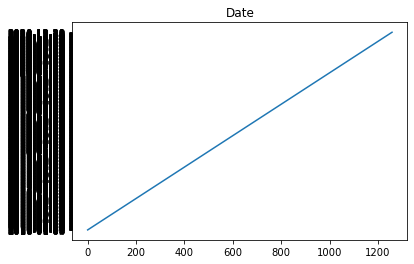

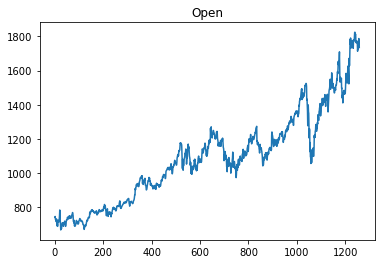

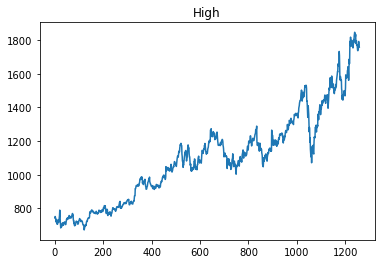

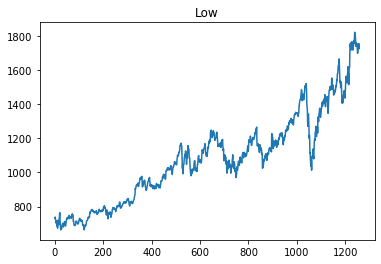

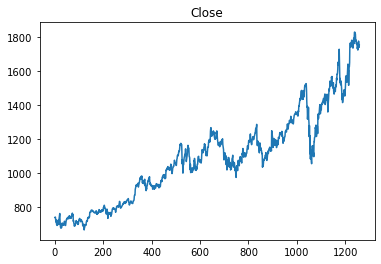

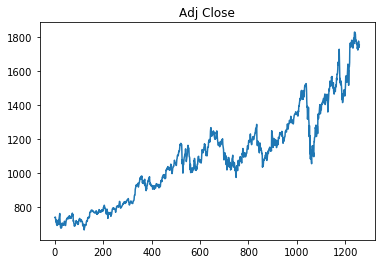

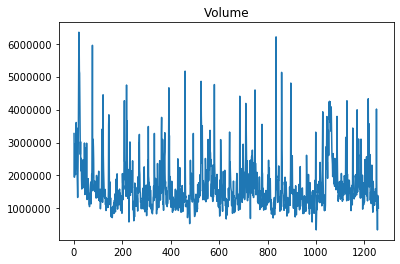

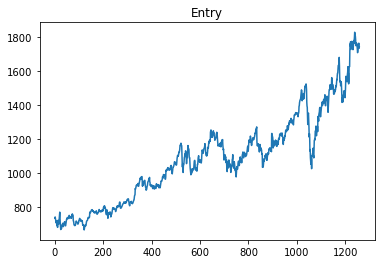

In [9]:
def plot_dataframe(dataframe):
  for column_name in dataframe.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(dataframe[column_name])

plot_dataframe(dataframe)

# Preprocessing

In [10]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    # shape : (n_batch, n_sequence, n_features)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
    targets = (targets - mean)/std # The Entry value is our target
    return samples, targets

In [11]:
# TimeseriesGenerator Check

data = np.array([[i, i**2,i**3,i**4] for i in range(11)])
#targets = np.array([[i**4] for i in range(11)])
targets = data

mean = data[:-1].mean(axis=0)[None,:]
std = data[:-1].std(axis=0)[None,:]

data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=1,
                               batch_size=2)
batch_0 = data_gen[0]
x, y = batch_0

print(np.array(x*std+mean,dtype = np.int))
print(y*std+mean)

[[[   0    0    0    0]
  [   1    1    1    1]
  [   2    4    8   16]
  [   3    9   27   81]
  [   4   16   64  256]
  [   5   25  125  625]
  [   6   36  216 1296]
  [   7   49  343 2401]
  [   8   64  512 4096]
  [   9   81  729 6561]]]
[[   10.   100.  1000. 10000.]]


In [12]:
n_sequence = 5
n_features = 7
n_batch = 32

def get_gen_train_test(dataframe):
  data = dataframe.drop(columns='Date').to_numpy()
  #targets = data[:,3, None] #add none to have same number of dimensions as data
  targets = data
  n_samples = data.shape[0]
  train_test_split=int(n_samples*0.9)

  data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
  data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

  return data_gen_train, data_gen_test

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

In [13]:
data_gen_train[0]

(array([[[-1.5081589 , -1.39145359, -1.55276085, ..., -0.84269373,
          -1.84776473, -1.54275536],
         [-0.35864595, -0.44659492, -0.69448496, ..., -1.53523482,
           1.03977731, -0.65472867],
         [-0.15684818,  0.56511382,  0.43021427, ...,  0.82038866,
          -0.16088245,  0.46349558],
         [ 0.49965335, -0.29489587,  0.54059033, ...,  0.62560574,
           0.55295894,  0.38065579],
         [ 1.52399967,  1.56783056,  1.27644121, ...,  0.93193414,
           0.41591093,  1.35333265]],
 
        [[-1.41551379, -1.82874085, -1.46187394, ..., -1.91159005,
          -1.26582492, -1.54499032],
         [-0.92627271, -0.21467245, -0.84772282, ...,  0.20812135,
           1.21563591, -0.73561577],
         [ 0.33445603,  0.35486573,  0.43530553, ...,  0.25974211,
          -0.16987052,  0.42410431],
         [ 0.92688325,  1.01470926,  1.25203918, ...,  1.03240296,
          -0.85610881,  1.21869059],
         [ 1.08044721,  0.67383831,  0.62225204, ...,  0.4113

In [14]:
data.shape

(11, 4)

In [15]:
# test on data
data = dataframe.drop(columns='Date').to_numpy()
targets = data

x_gen, y_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=1)[0]
print(x_gen)
print(y_gen)

x = data[None, :5,:]
mean = x.mean(axis=1)
std = x.std(axis=1)
x = (x - mean)/std
y = (data[5] - mean)/std
print('x:', x)
print('y:', y)

assert (x_gen == x).all()
assert (y_gen == y).all()

[[[ 0.9615339   0.16245112  0.55924707  0.69799102  0.69799102
    1.4178268   0.50040009]
  [ 1.45240481  1.37244886  1.37153545  0.76207352  0.76207352
   -1.06240397  1.37670208]
  [-0.88811819  0.63791534  0.3019813   0.85213473  0.85213473
   -1.06934509  0.35464386]
  [-0.84401139 -0.68485157 -0.78297272 -0.63996682 -0.63996682
    0.83796194 -0.77078337]
  [-0.68180913 -1.48796375 -1.4497911  -1.67223245 -1.67223245
   -0.12403968 -1.46096265]]]
[[-2.79326197 -3.67860772 -2.49073477 -1.53713276 -1.53713276 -0.79995462
  -2.68216834]]
x: [[[ 0.9615339   0.16245112  0.55924707  0.69799102  0.69799102
    1.4178268   0.50040009]
  [ 1.45240481  1.37244886  1.37153545  0.76207352  0.76207352
   -1.06240397  1.37670208]
  [-0.88811819  0.63791534  0.3019813   0.85213473  0.85213473
   -1.06934509  0.35464386]
  [-0.84401139 -0.68485157 -0.78297272 -0.63996682 -0.63996682
    0.83796194 -0.77078337]
  [-0.68180913 -1.48796375 -1.4497911  -1.67223245 -1.67223245
   -0.12403968 -1.46096

# Baseline 

In [16]:
# baseline: use previous days as estimation for the next
squared_error = 0
def mean_squared_error(X, lenght = 5):
  squared_error = 0
  for i in range(0, X.shape[0] - lenght):
    x = X[i:i+lenght]
    mean = x.mean()
    std = x.std()
    x = (x - mean)/std
    y = (X[i+lenght] - mean)/std
    squared_error += np.square(x[-1]-y)
  return squared_error/X.shape[0]

baseline_error = mean_squared_error(data[:,6])
baseline_error

4.317263898988826

In [17]:
data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=32)

# baseline: use previous day as estimation for the next
def mean_squared_error(dataset):
  mse=0
  for X_batch, y_batch in dataset:
    # X_batch.shape : (n_batch, n_sequence, n_features)
    #mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
    mse += np.mean(np.square(X_batch[:, -1, 6:7]-y_batch[:, 6:7]))
  mse /= len(dataset)
  return mse

baseline_error = mean_squared_error(data_gen)
baseline_error 

4.280646182369636

# Utilities

In [18]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

 

# GAN

## Perdidas

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse


## Generator

In [20]:
def make_generator_model():

  inputs = Input(shape=(n_sequence, n_features,))
  lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
  batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
  lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
  lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
  lstm_2 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
  batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
  lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
  lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
  #lstm_3 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_2_droput)
  #batch_norm3=tf.keras.layers.BatchNormalization()(lstm_3)
  #lstm_3_LRelu = LeakyReLU(alpha=0.3)(batch_norm3) 
  #lstm_3_droput = Dropout(0.3)(lstm_3_LRelu)
  #lstm_4 = LSTM(units=100, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_3_droput)
  #batch_norm4=tf.keras.layers.BatchNormalization()(lstm_4)
  #lstm_4_LRelu = LeakyReLU(alpha=0.3)(batch_norm4) 
  #lstm_4_droput = Dropout(0.5)(lstm_4_LRelu)
  output_dense = Dense(n_features, activation=None)(lstm_2_droput)
  output = LeakyReLU(alpha=0.3)(output_dense) 

  #prediction = Lambda( lambda x: x[..., 3:4])(output)
  #slice_model = Model(inputs = inputs, outputs = prediction)
  #slice_model.compile(loss='mse', metrics = ['mse', 'mae', 'mape', rmse, ar])
  #slice_model.summary()

  model = Model(inputs = inputs, outputs = output)
  #model.compile(loss=generator_loss)
  model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
  #model.compile(loss=None, metrics = [mse , mae, mape, rmse])
  model.summary()

  #return model, slice_model
  return model

  #history = model.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
   #                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
  


In [21]:
generator = make_generator_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 10)             720       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 10)             0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)               

## Discriminator

In [22]:
def make_discriminator_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
  model.add(Dropout(0.3))
  model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(Dropout(0.3))
  model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(Dropout(0.3))
  model.add(Dense(1 ,activation='sigmoid'))
  model.compile(loss=discriminator_loss)
  #history = model.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
   #                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
  return model


In [23]:
discriminator=make_discriminator_model()

In [24]:
learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

## Training

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
EPOCHS = 500

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

def train_step_def(sequences, sequences_end):
  # sequences is the real output

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_prediction = generator(sequences, training=True)

    sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

    real_output = discriminator(sequences_true, training=True)
    fake_output = discriminator(sequences_fake, training=True)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                            sequences_end, 
                                            fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
  generated_prediction = generator(sequences, training=False)

  sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
  sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

  real_output = discriminator(sequences_true, training=False)
  fake_output = discriminator(sequences_fake, training=False)

  gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
  disc_loss = discriminator_loss(real_output, fake_output)
  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [28]:
#@tf.function
#def train_step(sequences, sequences_end):
#  return train_step_def(sequences, sequences_end)

#@tf.function
#def test_step(sequences, sequences_end):
#  return test_step_def(sequences, sequences_end)

In [29]:
def train(dataset, dataset_val, epochs):
  history = np.empty(shape = (8, epochs))
  history_val = np.empty(shape = (8, epochs))
  len_dataset = len(dataset)
  len_dataset_val = len(dataset_val)
  for epoch in range(epochs):
    start = time.time()

    cur_dis_loss = 0
    cur_gen_loss = 0
    cur_gen_mse_loss = 0
    for sequence_batch, sequence_end_batch in dataset:
      aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                  tf.cast(sequence_end_batch, tf.float32))
      cur_gen_loss += aux_cur_losses[0]/len_dataset
      cur_dis_loss += aux_cur_losses[1]/len_dataset
      cur_gen_mse_loss += aux_cur_losses[2]/len_dataset

    #cur_gen_loss = generator.evaluate(dataset,verbose=False)
    cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]
    #cur_dis_loss = discriminator.evaluate(dataset,verbose=False)

    history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics
    #history[:, epoch] = cur_gen_loss, *cur_gen_slice_metrics

    #cur_gen_loss_val = generator.evaluate(dataset_val,verbose=False)
    cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

    #cur_dis_loss_val = discriminator.evaluate(dataset_val,verbose=False)

    cur_gen_loss_val = 0
    cur_dis_loss_val = 0
    cur_gen_mse_loss_val = 0
    for sequence_batch, sequence_end_batch in dataset_val:
      aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                     tf.cast(sequence_end_batch, tf.float32))
      cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
      cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
      cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


    history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

    print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
           .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))
      
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  return history, history_val

In [30]:
#history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

## Visualization

In [31]:
metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']

def plot_history(history, history_val):
  for i, metric_name in enumerate(metrics):  
    plt.figure()
    plt.title(metric_name)
    plt.plot(history[i], label='train')
    plt.plot(history_val[i], label='test')
    plt.legend()
  plt.show()

#plot_history(history, history_val)

In [32]:
def plot_frame(sequence, target, model):
  sequence, target = data_gen_test[0]
  y_pred = model.predict(sequence)[...,3]
  y_true = target[...,3]

  plt.figure()
  plt.title("Entry")
  plt.plot(y_true, label="true")
  plt.plot(y_pred, label="prediction")
  plt.legend()
  plt.show()

#plot_frame(*data_gen_test[0], generator)

In [33]:
def get_best_results(history):
  # get best mse
  min_index = np.argmin(history[3, :])

  return history[:, min_index]

#get_best_results(history_val)

# Test on all datasets

In [34]:
results = np.zeros((5,8))

### Google Stock

C:\Users\shusu\WorkSpace\stock_market_GAN\datasets\GOOG.csv
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5, 10)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
____________________________________________________________

Time for epoch 54 is 0.18760108947753906 sec Generator Loss: 1.039107322692871,  Discriminator_loss: 1.1052334308624268
Time for epoch 55 is 0.19900035858154297 sec Generator Loss: 1.0769217014312744,  Discriminator_loss: 1.1030266284942627
Time for epoch 56 is 0.19499897956848145 sec Generator Loss: 1.0468192100524902,  Discriminator_loss: 1.1297571659088135
Time for epoch 57 is 0.19100236892700195 sec Generator Loss: 1.0629388093948364,  Discriminator_loss: 1.1134977340698242
Time for epoch 58 is 0.19048118591308594 sec Generator Loss: 1.0532305240631104,  Discriminator_loss: 1.108229637145996
Time for epoch 59 is 0.19099903106689453 sec Generator Loss: 1.048545479774475,  Discriminator_loss: 1.1298317909240723
Time for epoch 60 is 0.18771886825561523 sec Generator Loss: 1.0321564674377441,  Discriminator_loss: 1.1297165155410767
Time for epoch 61 is 0.19065117835998535 sec Generator Loss: 1.0598678588867188,  Discriminator_loss: 1.1242809295654297
Time for epoch 62 is 0.194974899291

Time for epoch 123 is 0.19198155403137207 sec Generator Loss: 0.8814268708229065,  Discriminator_loss: 1.2809247970581055
Time for epoch 124 is 0.2019939422607422 sec Generator Loss: 0.8645652532577515,  Discriminator_loss: 1.2844812870025635
Time for epoch 125 is 0.21499967575073242 sec Generator Loss: 0.8685474395751953,  Discriminator_loss: 1.302365779876709
Time for epoch 126 is 0.1940004825592041 sec Generator Loss: 0.8819417357444763,  Discriminator_loss: 1.2648180723190308
Time for epoch 127 is 0.19334769248962402 sec Generator Loss: 0.8603894114494324,  Discriminator_loss: 1.3032584190368652
Time for epoch 128 is 0.19500184059143066 sec Generator Loss: 0.8741247653961182,  Discriminator_loss: 1.2905092239379883
Time for epoch 129 is 0.20499801635742188 sec Generator Loss: 0.8720683455467224,  Discriminator_loss: 1.284672498703003
Time for epoch 130 is 0.19306421279907227 sec Generator Loss: 0.8575273156166077,  Discriminator_loss: 1.3014627695083618
Time for epoch 131 is 0.1929

Time for epoch 191 is 0.19707727432250977 sec Generator Loss: 0.8269347548484802,  Discriminator_loss: 1.3406634330749512
Time for epoch 192 is 0.20714163780212402 sec Generator Loss: 0.8076435923576355,  Discriminator_loss: 1.3454720973968506
Time for epoch 193 is 0.20424699783325195 sec Generator Loss: 0.8149538636207581,  Discriminator_loss: 1.3548473119735718
Time for epoch 194 is 0.21197128295898438 sec Generator Loss: 0.8222876191139221,  Discriminator_loss: 1.3574683666229248
Time for epoch 195 is 0.19102907180786133 sec Generator Loss: 0.8059089779853821,  Discriminator_loss: 1.3554755449295044
Time for epoch 196 is 0.19146203994750977 sec Generator Loss: 0.8010333776473999,  Discriminator_loss: 1.3546438217163086
Time for epoch 197 is 0.19952082633972168 sec Generator Loss: 0.7997029423713684,  Discriminator_loss: 1.3588910102844238
Time for epoch 198 is 0.2030012607574463 sec Generator Loss: 0.7908651828765869,  Discriminator_loss: 1.3621207475662231
Time for epoch 199 is 0.2

Time for epoch 260 is 0.19705581665039062 sec Generator Loss: 0.7907482981681824,  Discriminator_loss: 1.3414602279663086
Time for epoch 261 is 0.19196653366088867 sec Generator Loss: 0.7990269660949707,  Discriminator_loss: 1.3446004390716553
Time for epoch 262 is 0.19671368598937988 sec Generator Loss: 0.8015402555465698,  Discriminator_loss: 1.3413164615631104
Time for epoch 263 is 0.1910848617553711 sec Generator Loss: 0.8043267130851746,  Discriminator_loss: 1.3385356664657593
Time for epoch 264 is 0.196671724319458 sec Generator Loss: 0.8046398758888245,  Discriminator_loss: 1.340531587600708
Time for epoch 265 is 0.21802234649658203 sec Generator Loss: 0.8271138668060303,  Discriminator_loss: 1.3428643941879272
Time for epoch 266 is 0.19331049919128418 sec Generator Loss: 0.8038248419761658,  Discriminator_loss: 1.343569278717041
Time for epoch 267 is 0.20359206199645996 sec Generator Loss: 0.7919705510139465,  Discriminator_loss: 1.341641902923584
Time for epoch 268 is 0.189356

Time for epoch 328 is 0.19299983978271484 sec Generator Loss: 0.7948172092437744,  Discriminator_loss: 1.3554469347000122
Time for epoch 329 is 0.21204137802124023 sec Generator Loss: 0.8026912212371826,  Discriminator_loss: 1.3397905826568604
Time for epoch 330 is 0.19330525398254395 sec Generator Loss: 0.8166314363479614,  Discriminator_loss: 1.3480008840560913
Time for epoch 331 is 0.19746041297912598 sec Generator Loss: 0.8177861571311951,  Discriminator_loss: 1.3260926008224487
Time for epoch 332 is 0.19115734100341797 sec Generator Loss: 0.8033590912818909,  Discriminator_loss: 1.3412224054336548
Time for epoch 333 is 0.19490814208984375 sec Generator Loss: 0.801643431186676,  Discriminator_loss: 1.3375951051712036
Time for epoch 334 is 0.19475388526916504 sec Generator Loss: 0.7890886068344116,  Discriminator_loss: 1.3563792705535889
Time for epoch 335 is 0.19552826881408691 sec Generator Loss: 0.7897809147834778,  Discriminator_loss: 1.3539257049560547
Time for epoch 336 is 0.1

Time for epoch 397 is 0.19115114212036133 sec Generator Loss: 0.8061507940292358,  Discriminator_loss: 1.3441215753555298
Time for epoch 398 is 0.19571685791015625 sec Generator Loss: 0.7982118725776672,  Discriminator_loss: 1.3446986675262451
Time for epoch 399 is 0.19299936294555664 sec Generator Loss: 0.7965182662010193,  Discriminator_loss: 1.3372728824615479
Time for epoch 400 is 0.2030012607574463 sec Generator Loss: 0.7980653047561646,  Discriminator_loss: 1.3405776023864746
Time for epoch 401 is 0.19759345054626465 sec Generator Loss: 0.7887535095214844,  Discriminator_loss: 1.3458726406097412
Time for epoch 402 is 0.18700718879699707 sec Generator Loss: 0.7951084971427917,  Discriminator_loss: 1.3581418991088867
Time for epoch 403 is 0.18802690505981445 sec Generator Loss: 0.8147427439689636,  Discriminator_loss: 1.3341580629348755
Time for epoch 404 is 0.1989734172821045 sec Generator Loss: 0.8001902103424072,  Discriminator_loss: 1.3441301584243774
Time for epoch 405 is 0.19

Time for epoch 465 is 0.2180018424987793 sec Generator Loss: 0.7933564186096191,  Discriminator_loss: 1.3556184768676758
Time for epoch 466 is 0.21199965476989746 sec Generator Loss: 0.7901513576507568,  Discriminator_loss: 1.352308988571167
Time for epoch 467 is 0.20509552955627441 sec Generator Loss: 0.7975730299949646,  Discriminator_loss: 1.357919454574585
Time for epoch 468 is 0.20444560050964355 sec Generator Loss: 0.7919990420341492,  Discriminator_loss: 1.3468258380889893
Time for epoch 469 is 0.2074902057647705 sec Generator Loss: 0.8053572773933411,  Discriminator_loss: 1.3471745252609253
Time for epoch 470 is 0.25699901580810547 sec Generator Loss: 0.7948273420333862,  Discriminator_loss: 1.347289800643921
Time for epoch 471 is 0.22139430046081543 sec Generator Loss: 0.7951635718345642,  Discriminator_loss: 1.3517032861709595
Time for epoch 472 is 0.21073365211486816 sec Generator Loss: 0.8000966310501099,  Discriminator_loss: 1.3469200134277344
Time for epoch 473 is 0.20924

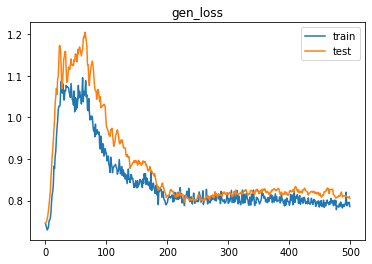

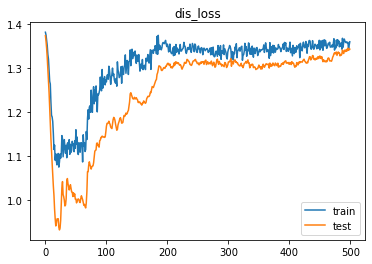

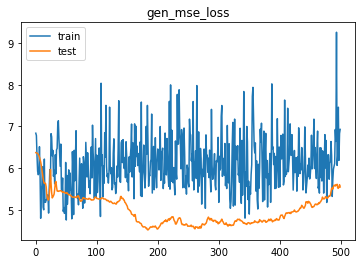

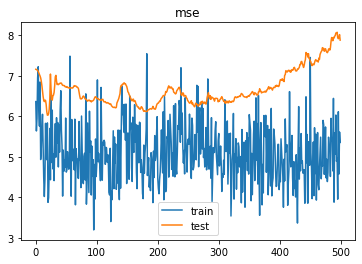

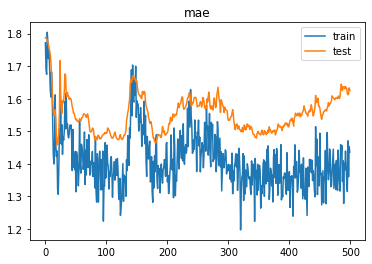

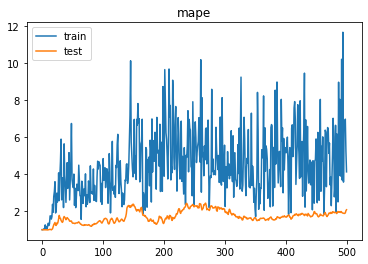

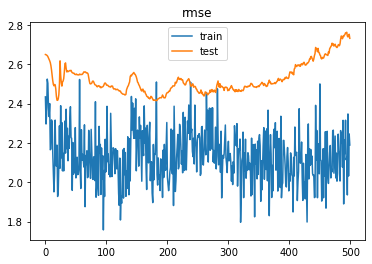

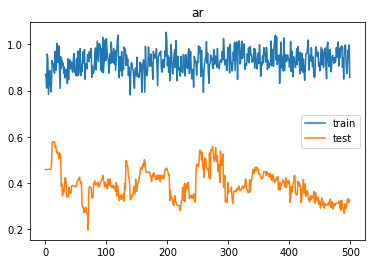

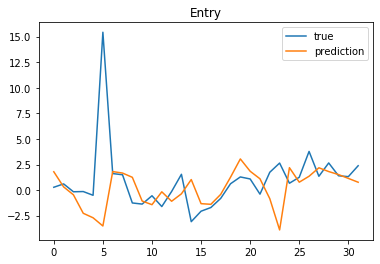

[MSE Baseline] train: 4.039802684834731  test: 2.812859025419686
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [1.09251547 0.95662713 5.23855019 6.0272789  1.46179807 1.33599269
 2.41609955 0.53528231]


In [35]:
i = 0 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
#data_path="GAN-stock-entry/datasets/"+data_name+".csv"
data_path="C:\\Users\\shusu\\WorkSpace\\stock_market_GAN\\datasets\\"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Apple Stock

C:\Users\shusu\WorkSpace\stock_market_GAN\datasets\AAPL.csv
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                840       
____________________________________________________________

Time for epoch 54 is 0.20699691772460938 sec Generator Loss: 0.9574611783027649,  Discriminator_loss: 1.2569513320922852
Time for epoch 55 is 0.2110002040863037 sec Generator Loss: 1.0392677783966064,  Discriminator_loss: 1.206233263015747
Time for epoch 56 is 0.2200028896331787 sec Generator Loss: 1.056644082069397,  Discriminator_loss: 1.1925455331802368
Time for epoch 57 is 0.2120041847229004 sec Generator Loss: 1.0675294399261475,  Discriminator_loss: 1.2010583877563477
Time for epoch 58 is 0.2019946575164795 sec Generator Loss: 1.0709989070892334,  Discriminator_loss: 1.1743121147155762
Time for epoch 59 is 0.19299840927124023 sec Generator Loss: 1.1008890867233276,  Discriminator_loss: 1.136333703994751
Time for epoch 60 is 0.19699716567993164 sec Generator Loss: 1.0655580759048462,  Discriminator_loss: 1.1548371315002441
Time for epoch 61 is 0.21297478675842285 sec Generator Loss: 1.0658148527145386,  Discriminator_loss: 1.1443864107131958
Time for epoch 62 is 0.1960015296936035

Time for epoch 123 is 0.21000146865844727 sec Generator Loss: 0.9315468668937683,  Discriminator_loss: 1.2696971893310547
Time for epoch 124 is 0.23299884796142578 sec Generator Loss: 0.922019362449646,  Discriminator_loss: 1.2609294652938843
Time for epoch 125 is 0.20252013206481934 sec Generator Loss: 0.8986724615097046,  Discriminator_loss: 1.2723089456558228
Time for epoch 126 is 0.20399928092956543 sec Generator Loss: 0.9262807965278625,  Discriminator_loss: 1.2665151357650757
Time for epoch 127 is 0.19502568244934082 sec Generator Loss: 0.902886688709259,  Discriminator_loss: 1.2864843606948853
Time for epoch 128 is 0.2035369873046875 sec Generator Loss: 0.8932884335517883,  Discriminator_loss: 1.2702844142913818
Time for epoch 129 is 0.20800161361694336 sec Generator Loss: 0.8937097787857056,  Discriminator_loss: 1.286100149154663
Time for epoch 130 is 0.19899725914001465 sec Generator Loss: 0.8802177906036377,  Discriminator_loss: 1.2884581089019775
Time for epoch 131 is 0.2100

Time for epoch 192 is 0.20703387260437012 sec Generator Loss: 0.8269925117492676,  Discriminator_loss: 1.3308857679367065
Time for epoch 193 is 0.20999979972839355 sec Generator Loss: 0.8321314454078674,  Discriminator_loss: 1.3261878490447998
Time for epoch 194 is 0.19900274276733398 sec Generator Loss: 0.8708399534225464,  Discriminator_loss: 1.2995649576187134
Time for epoch 195 is 0.20499825477600098 sec Generator Loss: 0.8585910797119141,  Discriminator_loss: 1.2909959554672241
Time for epoch 196 is 0.20000028610229492 sec Generator Loss: 0.8543092012405396,  Discriminator_loss: 1.3165775537490845
Time for epoch 197 is 0.19699954986572266 sec Generator Loss: 0.8587781190872192,  Discriminator_loss: 1.3065810203552246
Time for epoch 198 is 0.20100140571594238 sec Generator Loss: 0.8557566404342651,  Discriminator_loss: 1.3242357969284058
Time for epoch 199 is 0.22500014305114746 sec Generator Loss: 0.8403704762458801,  Discriminator_loss: 1.3203588724136353
Time for epoch 200 is 0.

Time for epoch 261 is 0.223069429397583 sec Generator Loss: 0.8185769319534302,  Discriminator_loss: 1.3397494554519653
Time for epoch 262 is 0.21001195907592773 sec Generator Loss: 0.8241490125656128,  Discriminator_loss: 1.3349329233169556
Time for epoch 263 is 0.19700002670288086 sec Generator Loss: 0.8327800035476685,  Discriminator_loss: 1.3220983743667603
Time for epoch 264 is 0.21199727058410645 sec Generator Loss: 0.8203543424606323,  Discriminator_loss: 1.337853193283081
Time for epoch 265 is 0.19614386558532715 sec Generator Loss: 0.8393537402153015,  Discriminator_loss: 1.3244476318359375
Time for epoch 266 is 0.19674372673034668 sec Generator Loss: 0.8139284253120422,  Discriminator_loss: 1.3450915813446045
Time for epoch 267 is 0.19560670852661133 sec Generator Loss: 0.8162592649459839,  Discriminator_loss: 1.3270245790481567
Time for epoch 268 is 0.2039949893951416 sec Generator Loss: 0.8345515727996826,  Discriminator_loss: 1.3383815288543701
Time for epoch 269 is 0.1930

Time for epoch 330 is 0.20067071914672852 sec Generator Loss: 0.7928735017776489,  Discriminator_loss: 1.3522019386291504
Time for epoch 331 is 0.1939985752105713 sec Generator Loss: 0.8066841959953308,  Discriminator_loss: 1.3475686311721802
Time for epoch 332 is 0.19702363014221191 sec Generator Loss: 0.8099995851516724,  Discriminator_loss: 1.3455228805541992
Time for epoch 333 is 0.20197606086730957 sec Generator Loss: 0.8016080260276794,  Discriminator_loss: 1.3581010103225708
Time for epoch 334 is 0.1862654685974121 sec Generator Loss: 0.7942502498626709,  Discriminator_loss: 1.3448817729949951
Time for epoch 335 is 0.18697595596313477 sec Generator Loss: 0.8149920701980591,  Discriminator_loss: 1.3508498668670654
Time for epoch 336 is 0.19099926948547363 sec Generator Loss: 0.7997695207595825,  Discriminator_loss: 1.352890968322754
Time for epoch 337 is 0.2030014991760254 sec Generator Loss: 0.7880300283432007,  Discriminator_loss: 1.3592092990875244
Time for epoch 338 is 0.1979

Time for epoch 399 is 0.18897509574890137 sec Generator Loss: 0.7866902351379395,  Discriminator_loss: 1.358520746231079
Time for epoch 400 is 0.1919996738433838 sec Generator Loss: 0.7951764464378357,  Discriminator_loss: 1.3553147315979004
Time for epoch 401 is 0.1920003890991211 sec Generator Loss: 0.7901167869567871,  Discriminator_loss: 1.372365117073059
Time for epoch 402 is 0.18653559684753418 sec Generator Loss: 0.7799779176712036,  Discriminator_loss: 1.3655719757080078
Time for epoch 403 is 0.19700121879577637 sec Generator Loss: 0.7910912036895752,  Discriminator_loss: 1.3512988090515137
Time for epoch 404 is 0.19699811935424805 sec Generator Loss: 0.7970201373100281,  Discriminator_loss: 1.3526365756988525
Time for epoch 405 is 0.196000337600708 sec Generator Loss: 0.7998218536376953,  Discriminator_loss: 1.3478211164474487
Time for epoch 406 is 0.1939709186553955 sec Generator Loss: 0.7975456714630127,  Discriminator_loss: 1.3446863889694214
Time for epoch 407 is 0.1889994

Time for epoch 468 is 0.18998217582702637 sec Generator Loss: 0.7997719049453735,  Discriminator_loss: 1.3545355796813965
Time for epoch 469 is 0.18599867820739746 sec Generator Loss: 0.8078029751777649,  Discriminator_loss: 1.347374677658081
Time for epoch 470 is 0.19100189208984375 sec Generator Loss: 0.7953117489814758,  Discriminator_loss: 1.3621838092803955
Time for epoch 471 is 0.21000242233276367 sec Generator Loss: 0.7767658233642578,  Discriminator_loss: 1.365522861480713
Time for epoch 472 is 0.19899821281433105 sec Generator Loss: 0.7931997179985046,  Discriminator_loss: 1.351449966430664
Time for epoch 473 is 0.20799875259399414 sec Generator Loss: 0.8050992488861084,  Discriminator_loss: 1.3506509065628052
Time for epoch 474 is 0.20400094985961914 sec Generator Loss: 0.7920147776603699,  Discriminator_loss: 1.3610923290252686
Time for epoch 475 is 0.19699978828430176 sec Generator Loss: 0.8018694519996643,  Discriminator_loss: 1.3581770658493042
Time for epoch 476 is 0.202

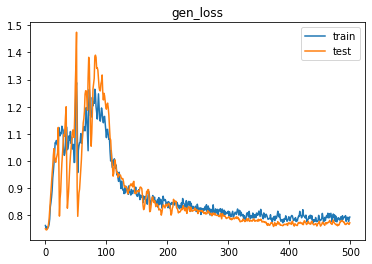

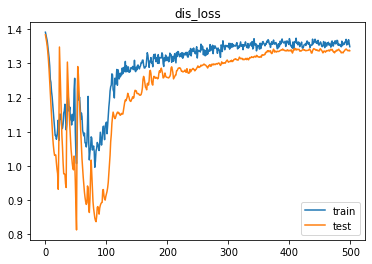

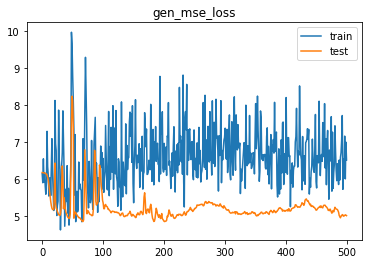

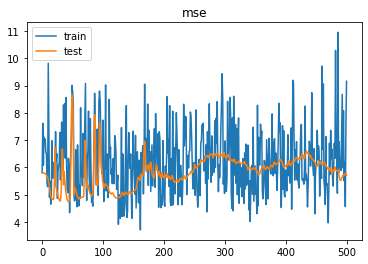

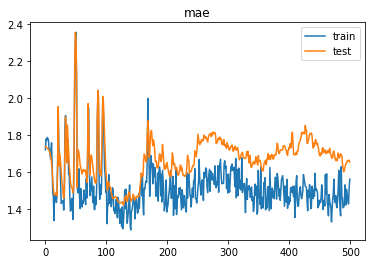

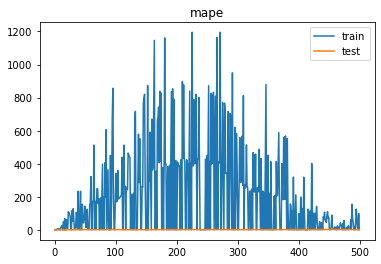

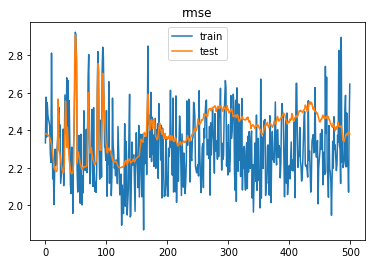

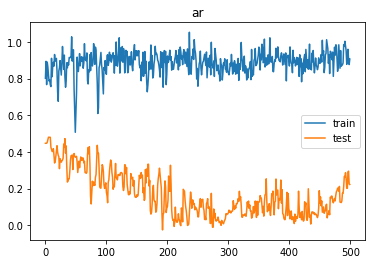

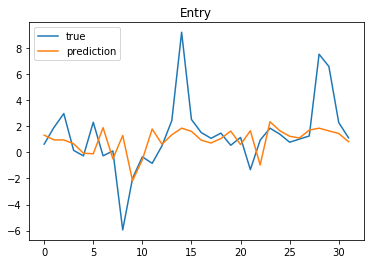

[MSE Baseline] train: 4.4906856271699835  test: 3.883730321570804
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [1.07283139 1.02903867 4.96076536 4.74275541 1.51732111 2.24614859
 2.16777945 0.38116559]


In [38]:
i = 1 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
#data_path="GAN-stock-entry/datasets/"+data_name+".csv"
data_path="C:\\Users\\shusu\\WorkSpace\\stock_market_GAN\\datasets\\"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Amazon Stock

C:\Users\shusu\WorkSpace\stock_market_GAN\datasets\AMZN.csv
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                840       
___________________________________________________________

Time for epoch 54 is 0.20800209045410156 sec Generator Loss: 0.9222667813301086,  Discriminator_loss: 1.2655010223388672
Time for epoch 55 is 0.2089998722076416 sec Generator Loss: 0.9129865765571594,  Discriminator_loss: 1.2395740747451782
Time for epoch 56 is 0.2089986801147461 sec Generator Loss: 0.931082010269165,  Discriminator_loss: 1.2578232288360596
Time for epoch 57 is 0.21200084686279297 sec Generator Loss: 0.9229146242141724,  Discriminator_loss: 1.2469234466552734
Time for epoch 58 is 0.19999980926513672 sec Generator Loss: 0.9180970788002014,  Discriminator_loss: 1.2501780986785889
Time for epoch 59 is 0.19000029563903809 sec Generator Loss: 0.9329505562782288,  Discriminator_loss: 1.2416956424713135
Time for epoch 60 is 0.1919999122619629 sec Generator Loss: 0.9186348915100098,  Discriminator_loss: 1.242956280708313
Time for epoch 61 is 0.190321683883667 sec Generator Loss: 0.9145287871360779,  Discriminator_loss: 1.2557233572006226
Time for epoch 62 is 0.193314790725708 

Time for epoch 122 is 0.22263813018798828 sec Generator Loss: 0.8572217226028442,  Discriminator_loss: 1.2906954288482666
Time for epoch 123 is 0.2330305576324463 sec Generator Loss: 0.8521584868431091,  Discriminator_loss: 1.3199812173843384
Time for epoch 124 is 0.20351576805114746 sec Generator Loss: 0.8592085242271423,  Discriminator_loss: 1.3078837394714355
Time for epoch 125 is 0.21699976921081543 sec Generator Loss: 0.8342961668968201,  Discriminator_loss: 1.310684084892273
Time for epoch 126 is 0.19966483116149902 sec Generator Loss: 0.8474555015563965,  Discriminator_loss: 1.304446816444397
Time for epoch 127 is 0.1999967098236084 sec Generator Loss: 0.836315929889679,  Discriminator_loss: 1.3306528329849243
Time for epoch 128 is 0.20302534103393555 sec Generator Loss: 0.8444655537605286,  Discriminator_loss: 1.3273768424987793
Time for epoch 129 is 0.21000218391418457 sec Generator Loss: 0.8285516500473022,  Discriminator_loss: 1.331358790397644
Time for epoch 130 is 0.196997

Time for epoch 191 is 0.19284415245056152 sec Generator Loss: 0.7917582392692566,  Discriminator_loss: 1.353676199913025
Time for epoch 192 is 0.1930248737335205 sec Generator Loss: 0.7905791997909546,  Discriminator_loss: 1.3611526489257812
Time for epoch 193 is 0.18899965286254883 sec Generator Loss: 0.7949512004852295,  Discriminator_loss: 1.3484861850738525
Time for epoch 194 is 0.19470858573913574 sec Generator Loss: 0.7927138805389404,  Discriminator_loss: 1.3445842266082764
Time for epoch 195 is 0.19299960136413574 sec Generator Loss: 0.7874660491943359,  Discriminator_loss: 1.3487964868545532
Time for epoch 196 is 0.1898953914642334 sec Generator Loss: 0.7955540418624878,  Discriminator_loss: 1.3320809602737427
Time for epoch 197 is 0.18802785873413086 sec Generator Loss: 0.7995281219482422,  Discriminator_loss: 1.3463294506072998
Time for epoch 198 is 0.19500041007995605 sec Generator Loss: 0.7793834209442139,  Discriminator_loss: 1.361746072769165
Time for epoch 199 is 0.1911

Time for epoch 260 is 0.1928999423980713 sec Generator Loss: 0.8017252683639526,  Discriminator_loss: 1.3422847986221313
Time for epoch 261 is 0.2098371982574463 sec Generator Loss: 0.80698162317276,  Discriminator_loss: 1.3427116870880127
Time for epoch 262 is 0.20405125617980957 sec Generator Loss: 0.797722339630127,  Discriminator_loss: 1.3478304147720337
Time for epoch 263 is 0.1969738006591797 sec Generator Loss: 0.7833554744720459,  Discriminator_loss: 1.356853723526001
Time for epoch 264 is 0.21502447128295898 sec Generator Loss: 0.7913897037506104,  Discriminator_loss: 1.3528001308441162
Time for epoch 265 is 0.1949782371520996 sec Generator Loss: 0.7984926700592041,  Discriminator_loss: 1.3456884622573853
Time for epoch 266 is 0.2201225757598877 sec Generator Loss: 0.7958048582077026,  Discriminator_loss: 1.337267518043518
Time for epoch 267 is 0.22804832458496094 sec Generator Loss: 0.8065590858459473,  Discriminator_loss: 1.3463976383209229
Time for epoch 268 is 0.2079977989

Time for epoch 329 is 0.19350361824035645 sec Generator Loss: 0.7759791612625122,  Discriminator_loss: 1.364898920059204
Time for epoch 330 is 0.1897885799407959 sec Generator Loss: 0.7807038426399231,  Discriminator_loss: 1.348461627960205
Time for epoch 331 is 0.19873833656311035 sec Generator Loss: 0.7790294289588928,  Discriminator_loss: 1.368468999862671
Time for epoch 332 is 0.19626283645629883 sec Generator Loss: 0.7633714079856873,  Discriminator_loss: 1.3735359907150269
Time for epoch 333 is 0.19500112533569336 sec Generator Loss: 0.7626349925994873,  Discriminator_loss: 1.381198525428772
Time for epoch 334 is 0.20200061798095703 sec Generator Loss: 0.7822059988975525,  Discriminator_loss: 1.3654651641845703
Time for epoch 335 is 0.20900416374206543 sec Generator Loss: 0.7791393995285034,  Discriminator_loss: 1.369305968284607
Time for epoch 336 is 0.2129969596862793 sec Generator Loss: 0.773605465888977,  Discriminator_loss: 1.3640083074569702
Time for epoch 337 is 0.20499849

Time for epoch 397 is 0.20261907577514648 sec Generator Loss: 0.7787359952926636,  Discriminator_loss: 1.3715016841888428
Time for epoch 398 is 0.2125697135925293 sec Generator Loss: 0.7635424137115479,  Discriminator_loss: 1.3633356094360352
Time for epoch 399 is 0.2070009708404541 sec Generator Loss: 0.7685390710830688,  Discriminator_loss: 1.3710609674453735
Time for epoch 400 is 0.19299936294555664 sec Generator Loss: 0.7648165225982666,  Discriminator_loss: 1.372451901435852
Time for epoch 401 is 0.18899989128112793 sec Generator Loss: 0.7699365019798279,  Discriminator_loss: 1.3686997890472412
Time for epoch 402 is 0.18693137168884277 sec Generator Loss: 0.7846484184265137,  Discriminator_loss: 1.3657606840133667
Time for epoch 403 is 0.1979987621307373 sec Generator Loss: 0.7666909694671631,  Discriminator_loss: 1.3694443702697754
Time for epoch 404 is 0.18999767303466797 sec Generator Loss: 0.7723187208175659,  Discriminator_loss: 1.3711820840835571
Time for epoch 405 is 0.1936

Time for epoch 465 is 0.209181547164917 sec Generator Loss: 0.7795181274414062,  Discriminator_loss: 1.3613303899765015
Time for epoch 466 is 0.20025968551635742 sec Generator Loss: 0.7875322103500366,  Discriminator_loss: 1.3580888509750366
Time for epoch 467 is 0.19032073020935059 sec Generator Loss: 0.7710740566253662,  Discriminator_loss: 1.369887113571167
Time for epoch 468 is 0.20432400703430176 sec Generator Loss: 0.7751455307006836,  Discriminator_loss: 1.3706988096237183
Time for epoch 469 is 0.19900012016296387 sec Generator Loss: 0.7708431482315063,  Discriminator_loss: 1.3628753423690796
Time for epoch 470 is 0.21902751922607422 sec Generator Loss: 0.771543025970459,  Discriminator_loss: 1.3693902492523193
Time for epoch 471 is 0.22532892227172852 sec Generator Loss: 0.769846498966217,  Discriminator_loss: 1.3677167892456055
Time for epoch 472 is 0.1979990005493164 sec Generator Loss: 0.7650287747383118,  Discriminator_loss: 1.3686519861221313
Time for epoch 473 is 0.192999

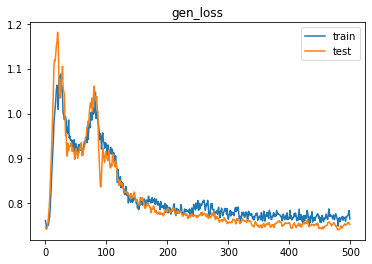

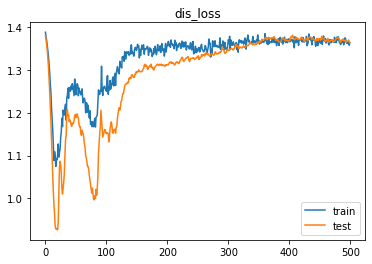

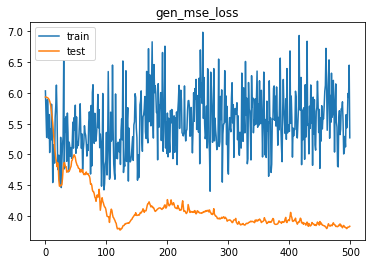

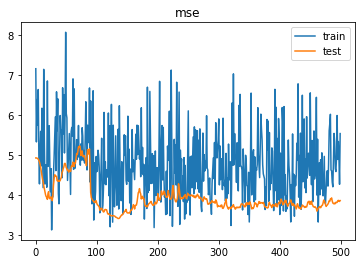

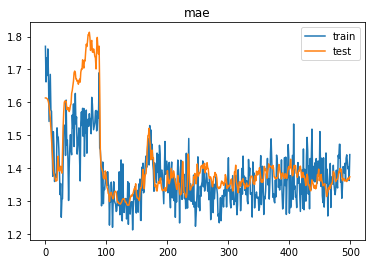

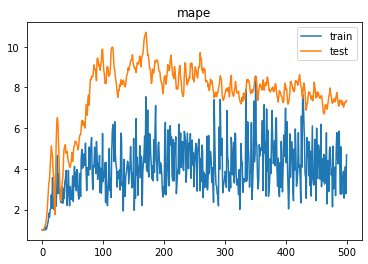

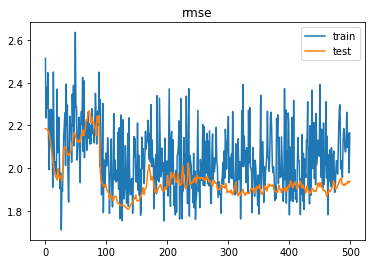

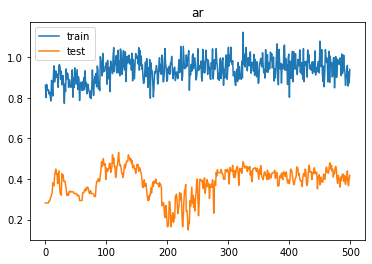

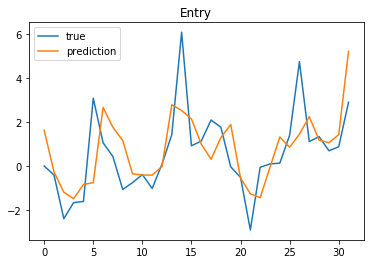

[MSE Baseline] train: 3.3356200672625227  test: 3.8536905955453555
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [0.81926697 1.27133775 3.88104582 3.42226362 1.28773415 8.07656384
 1.80744553 0.48558092]


In [39]:
i = 2 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]
data_name = data_names[i]
#data_path="GAN-stock-entry/datasets/"+data_name+".csv"
data_path="C:\\Users\\shusu\\WorkSpace\\stock_market_GAN\\datasets\\"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Facebook Stock

C:\Users\shusu\WorkSpace\stock_market_GAN\datasets\FB.csv
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_12 (Batc (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 10)                840       
_____________________________________________________________

Time for epoch 55 is 0.2050013542175293 sec Generator Loss: 1.0138957500457764,  Discriminator_loss: 1.1983377933502197
Time for epoch 56 is 0.20299935340881348 sec Generator Loss: 1.0493643283843994,  Discriminator_loss: 1.1596078872680664
Time for epoch 57 is 0.20853805541992188 sec Generator Loss: 1.0007843971252441,  Discriminator_loss: 1.207565426826477
Time for epoch 58 is 0.20102620124816895 sec Generator Loss: 1.0197635889053345,  Discriminator_loss: 1.1678872108459473
Time for epoch 59 is 0.19899940490722656 sec Generator Loss: 1.0153002738952637,  Discriminator_loss: 1.1718541383743286
Time for epoch 60 is 0.2048656940460205 sec Generator Loss: 1.014339566230774,  Discriminator_loss: 1.1953755617141724
Time for epoch 61 is 0.21845531463623047 sec Generator Loss: 1.01767897605896,  Discriminator_loss: 1.19289231300354
Time for epoch 62 is 0.22194385528564453 sec Generator Loss: 1.0063129663467407,  Discriminator_loss: 1.1764529943466187
Time for epoch 63 is 0.21201157569885254

Time for epoch 123 is 0.1933000087738037 sec Generator Loss: 0.8930042386054993,  Discriminator_loss: 1.275473713874817
Time for epoch 124 is 0.19999909400939941 sec Generator Loss: 0.8919396996498108,  Discriminator_loss: 1.2814764976501465
Time for epoch 125 is 0.1949605941772461 sec Generator Loss: 0.9132073521614075,  Discriminator_loss: 1.2644338607788086
Time for epoch 126 is 0.20799708366394043 sec Generator Loss: 0.8757135272026062,  Discriminator_loss: 1.3128410577774048
Time for epoch 127 is 0.22400283813476562 sec Generator Loss: 0.8923141956329346,  Discriminator_loss: 1.2758795022964478
Time for epoch 128 is 0.19946002960205078 sec Generator Loss: 0.8824284672737122,  Discriminator_loss: 1.2820360660552979
Time for epoch 129 is 0.19899940490722656 sec Generator Loss: 0.901228129863739,  Discriminator_loss: 1.2823371887207031
Time for epoch 130 is 0.2069997787475586 sec Generator Loss: 0.8880966901779175,  Discriminator_loss: 1.282555103302002
Time for epoch 131 is 0.200574

Time for epoch 192 is 0.19845819473266602 sec Generator Loss: 0.8346661925315857,  Discriminator_loss: 1.3373445272445679
Time for epoch 193 is 0.19700217247009277 sec Generator Loss: 0.834245502948761,  Discriminator_loss: 1.341398000717163
Time for epoch 194 is 0.19699859619140625 sec Generator Loss: 0.8345230221748352,  Discriminator_loss: 1.3238695859909058
Time for epoch 195 is 0.19603443145751953 sec Generator Loss: 0.8359513282775879,  Discriminator_loss: 1.3366392850875854
Time for epoch 196 is 0.20199966430664062 sec Generator Loss: 0.8299345374107361,  Discriminator_loss: 1.3528773784637451
Time for epoch 197 is 0.1939985752105713 sec Generator Loss: 0.8583453893661499,  Discriminator_loss: 1.3220486640930176
Time for epoch 198 is 0.1971302032470703 sec Generator Loss: 0.815050482749939,  Discriminator_loss: 1.3370872735977173
Time for epoch 199 is 0.1926417350769043 sec Generator Loss: 0.826819121837616,  Discriminator_loss: 1.3472734689712524
Time for epoch 200 is 0.1948974

Time for epoch 260 is 0.19800233840942383 sec Generator Loss: 0.8277215361595154,  Discriminator_loss: 1.3465837240219116
Time for epoch 261 is 0.19699811935424805 sec Generator Loss: 0.8207545876502991,  Discriminator_loss: 1.3517237901687622
Time for epoch 262 is 0.20101165771484375 sec Generator Loss: 0.8267592787742615,  Discriminator_loss: 1.3551499843597412
Time for epoch 263 is 0.2050004005432129 sec Generator Loss: 0.8288114070892334,  Discriminator_loss: 1.341639518737793
Time for epoch 264 is 0.19800257682800293 sec Generator Loss: 0.8088493347167969,  Discriminator_loss: 1.3633816242218018
Time for epoch 265 is 0.2020125389099121 sec Generator Loss: 0.8208381533622742,  Discriminator_loss: 1.3510026931762695
Time for epoch 266 is 0.21400237083435059 sec Generator Loss: 0.8149596452713013,  Discriminator_loss: 1.346411943435669
Time for epoch 267 is 0.20101284980773926 sec Generator Loss: 0.8092637658119202,  Discriminator_loss: 1.3566865921020508
Time for epoch 268 is 0.2022

Time for epoch 329 is 0.1878678798675537 sec Generator Loss: 0.7848315834999084,  Discriminator_loss: 1.3520413637161255
Time for epoch 330 is 0.18557476997375488 sec Generator Loss: 0.7910487651824951,  Discriminator_loss: 1.3478941917419434
Time for epoch 331 is 0.190901517868042 sec Generator Loss: 0.7870063781738281,  Discriminator_loss: 1.3640578985214233
Time for epoch 332 is 0.19490790367126465 sec Generator Loss: 0.7963380813598633,  Discriminator_loss: 1.3471304178237915
Time for epoch 333 is 0.1891779899597168 sec Generator Loss: 0.8034881353378296,  Discriminator_loss: 1.3462191820144653
Time for epoch 334 is 0.18924999237060547 sec Generator Loss: 0.8168608546257019,  Discriminator_loss: 1.350569725036621
Time for epoch 335 is 0.18892788887023926 sec Generator Loss: 0.8088387250900269,  Discriminator_loss: 1.3623477220535278
Time for epoch 336 is 0.19499874114990234 sec Generator Loss: 0.7894391417503357,  Discriminator_loss: 1.3606555461883545
Time for epoch 337 is 0.19303

Time for epoch 397 is 0.19705724716186523 sec Generator Loss: 0.7959507703781128,  Discriminator_loss: 1.3588835000991821
Time for epoch 398 is 0.1973891258239746 sec Generator Loss: 0.8020430207252502,  Discriminator_loss: 1.355629324913025
Time for epoch 399 is 0.205000638961792 sec Generator Loss: 0.7976628541946411,  Discriminator_loss: 1.3535608053207397
Time for epoch 400 is 0.2025744915008545 sec Generator Loss: 0.8204476237297058,  Discriminator_loss: 1.3533344268798828
Time for epoch 401 is 0.1960303783416748 sec Generator Loss: 0.7802302241325378,  Discriminator_loss: 1.3737847805023193
Time for epoch 402 is 0.1930103302001953 sec Generator Loss: 0.8165869116783142,  Discriminator_loss: 1.3515739440917969
Time for epoch 403 is 0.1980290412902832 sec Generator Loss: 0.7883076071739197,  Discriminator_loss: 1.367555022239685
Time for epoch 404 is 0.19597172737121582 sec Generator Loss: 0.7975433468818665,  Discriminator_loss: 1.3591334819793701
Time for epoch 405 is 0.205001115

Time for epoch 465 is 0.18700814247131348 sec Generator Loss: 0.7847216129302979,  Discriminator_loss: 1.365838885307312
Time for epoch 466 is 0.19589972496032715 sec Generator Loss: 0.7851321697235107,  Discriminator_loss: 1.3620332479476929
Time for epoch 467 is 0.18993616104125977 sec Generator Loss: 0.7931306958198547,  Discriminator_loss: 1.3620507717132568
Time for epoch 468 is 0.1958475112915039 sec Generator Loss: 0.7836502194404602,  Discriminator_loss: 1.3581098318099976
Time for epoch 469 is 0.19266176223754883 sec Generator Loss: 0.7833746075630188,  Discriminator_loss: 1.3575502634048462
Time for epoch 470 is 0.18892669677734375 sec Generator Loss: 0.7841522097587585,  Discriminator_loss: 1.3638334274291992
Time for epoch 471 is 0.19999957084655762 sec Generator Loss: 0.7999961972236633,  Discriminator_loss: 1.356044054031372
Time for epoch 472 is 0.19263005256652832 sec Generator Loss: 0.7942009568214417,  Discriminator_loss: 1.3612964153289795
Time for epoch 473 is 0.193

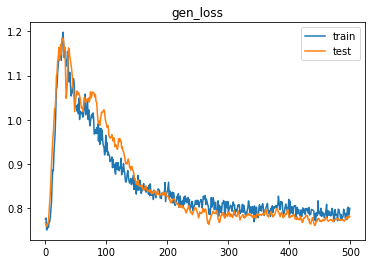

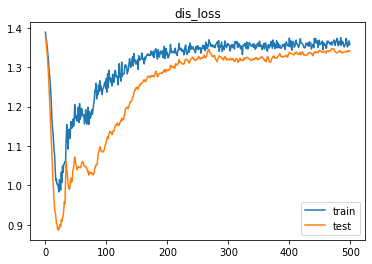

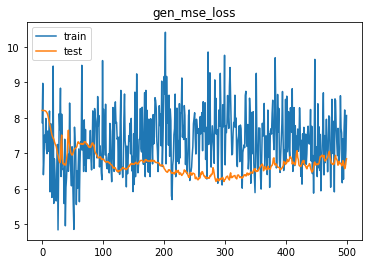

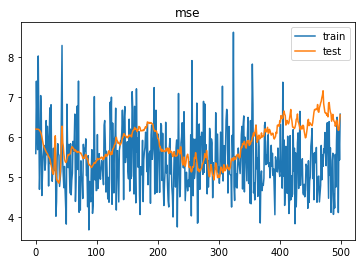

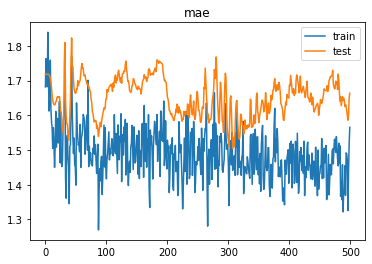

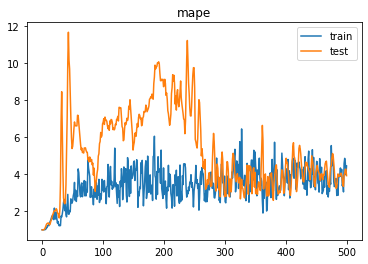

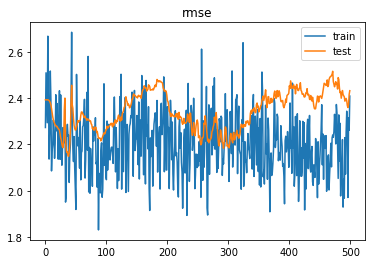

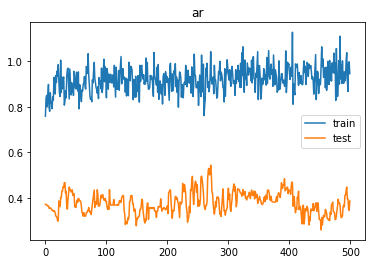

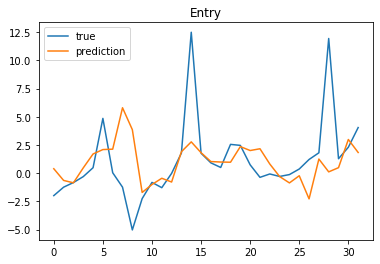

[MSE Baseline] train: 4.16754441123647  test: 8.240952977742106
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [1.16262627 0.99404156 6.66607666 4.84942436 1.52801621 2.5078299
 2.14810371 0.41989392]


In [40]:
i = 3 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
#data_path="GAN-stock-entry/datasets/"+data_name+".csv"
data_path="C:\\Users\\shusu\\WorkSpace\\stock_market_GAN\\datasets\\"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Tesla Stock

C:\Users\shusu\WorkSpace\stock_market_GAN\datasets\TSLA.csv
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_14 (Batc (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 10)                840       
___________________________________________________________

Time for epoch 54 is 0.19097232818603516 sec Generator Loss: 1.1920362710952759,  Discriminator_loss: 1.0030038356781006
Time for epoch 55 is 0.19104695320129395 sec Generator Loss: 1.1986511945724487,  Discriminator_loss: 1.0219446420669556
Time for epoch 56 is 0.18587708473205566 sec Generator Loss: 1.2014001607894897,  Discriminator_loss: 0.9763137698173523
Time for epoch 57 is 0.19199824333190918 sec Generator Loss: 1.2165358066558838,  Discriminator_loss: 0.9707711935043335
Time for epoch 58 is 0.1945037841796875 sec Generator Loss: 1.2241671085357666,  Discriminator_loss: 0.9790710210800171
Time for epoch 59 is 0.19797635078430176 sec Generator Loss: 1.1939858198165894,  Discriminator_loss: 0.9859848022460938
Time for epoch 60 is 0.19451022148132324 sec Generator Loss: 1.189401626586914,  Discriminator_loss: 0.9786205887794495
Time for epoch 61 is 0.2152724266052246 sec Generator Loss: 1.192601203918457,  Discriminator_loss: 1.005311369895935
Time for epoch 62 is 0.19499945640563

Time for epoch 123 is 0.18680834770202637 sec Generator Loss: 0.9124802947044373,  Discriminator_loss: 1.286278247833252
Time for epoch 124 is 0.19598650932312012 sec Generator Loss: 0.9205412268638611,  Discriminator_loss: 1.2721655368804932
Time for epoch 125 is 0.19099879264831543 sec Generator Loss: 0.8981229662895203,  Discriminator_loss: 1.3053169250488281
Time for epoch 126 is 0.20799970626831055 sec Generator Loss: 0.8964475393295288,  Discriminator_loss: 1.2859233617782593
Time for epoch 127 is 0.21700263023376465 sec Generator Loss: 0.876730740070343,  Discriminator_loss: 1.3162113428115845
Time for epoch 128 is 0.1919994354248047 sec Generator Loss: 0.8880056142807007,  Discriminator_loss: 1.3343156576156616
Time for epoch 129 is 0.19834399223327637 sec Generator Loss: 0.8930476903915405,  Discriminator_loss: 1.3090451955795288
Time for epoch 130 is 0.19902467727661133 sec Generator Loss: 0.9096860885620117,  Discriminator_loss: 1.3127609491348267
Time for epoch 131 is 0.190

Time for epoch 191 is 0.18702483177185059 sec Generator Loss: 0.8163537979125977,  Discriminator_loss: 1.3470672369003296
Time for epoch 192 is 0.19342398643493652 sec Generator Loss: 0.8238140344619751,  Discriminator_loss: 1.3474336862564087
Time for epoch 193 is 0.1979992389678955 sec Generator Loss: 0.8254895806312561,  Discriminator_loss: 1.3329274654388428
Time for epoch 194 is 0.19053292274475098 sec Generator Loss: 0.8128412365913391,  Discriminator_loss: 1.3442037105560303
Time for epoch 195 is 0.18915176391601562 sec Generator Loss: 0.8111446499824524,  Discriminator_loss: 1.3402683734893799
Time for epoch 196 is 0.19687891006469727 sec Generator Loss: 0.8078416585922241,  Discriminator_loss: 1.345773696899414
Time for epoch 197 is 0.19226884841918945 sec Generator Loss: 0.8207069635391235,  Discriminator_loss: 1.32673978805542
Time for epoch 198 is 0.19299960136413574 sec Generator Loss: 0.8109338283538818,  Discriminator_loss: 1.357851266860962
Time for epoch 199 is 0.19300

Time for epoch 260 is 0.20496749877929688 sec Generator Loss: 0.778805673122406,  Discriminator_loss: 1.3530181646347046
Time for epoch 261 is 0.20299816131591797 sec Generator Loss: 0.7873950600624084,  Discriminator_loss: 1.362381100654602
Time for epoch 262 is 0.19400334358215332 sec Generator Loss: 0.7838568687438965,  Discriminator_loss: 1.364690899848938
Time for epoch 263 is 0.20099830627441406 sec Generator Loss: 0.7853237390518188,  Discriminator_loss: 1.3653490543365479
Time for epoch 264 is 0.19706463813781738 sec Generator Loss: 0.7773597240447998,  Discriminator_loss: 1.3586616516113281
Time for epoch 265 is 0.1939990520477295 sec Generator Loss: 0.7787715196609497,  Discriminator_loss: 1.3644236326217651
Time for epoch 266 is 0.1968371868133545 sec Generator Loss: 0.7780008912086487,  Discriminator_loss: 1.3642863035202026
Time for epoch 267 is 0.19798946380615234 sec Generator Loss: 0.7770193815231323,  Discriminator_loss: 1.350221872329712
Time for epoch 268 is 0.190859

Time for epoch 328 is 0.19597768783569336 sec Generator Loss: 0.7641119956970215,  Discriminator_loss: 1.366326093673706
Time for epoch 329 is 0.19281935691833496 sec Generator Loss: 0.7654216885566711,  Discriminator_loss: 1.3650633096694946
Time for epoch 330 is 0.20300054550170898 sec Generator Loss: 0.8062524795532227,  Discriminator_loss: 1.3535128831863403
Time for epoch 331 is 0.19126534461975098 sec Generator Loss: 0.781856894493103,  Discriminator_loss: 1.3554039001464844
Time for epoch 332 is 0.19299721717834473 sec Generator Loss: 0.7795286774635315,  Discriminator_loss: 1.3434557914733887
Time for epoch 333 is 0.1920013427734375 sec Generator Loss: 0.7863364815711975,  Discriminator_loss: 1.3612107038497925
Time for epoch 334 is 0.19238901138305664 sec Generator Loss: 0.784231960773468,  Discriminator_loss: 1.356495976448059
Time for epoch 335 is 0.18899226188659668 sec Generator Loss: 0.8016223311424255,  Discriminator_loss: 1.3499361276626587
Time for epoch 336 is 0.18799

Time for epoch 397 is 0.19002628326416016 sec Generator Loss: 0.7722928524017334,  Discriminator_loss: 1.3793091773986816
Time for epoch 398 is 0.18903851509094238 sec Generator Loss: 0.7818207144737244,  Discriminator_loss: 1.3547298908233643
Time for epoch 399 is 0.1949446201324463 sec Generator Loss: 0.7689904570579529,  Discriminator_loss: 1.3581881523132324
Time for epoch 400 is 0.19196224212646484 sec Generator Loss: 0.7851048707962036,  Discriminator_loss: 1.3463435173034668
Time for epoch 401 is 0.19163274765014648 sec Generator Loss: 0.7905939221382141,  Discriminator_loss: 1.348937749862671
Time for epoch 402 is 0.19393706321716309 sec Generator Loss: 0.7726309895515442,  Discriminator_loss: 1.360281229019165
Time for epoch 403 is 0.19183802604675293 sec Generator Loss: 0.801038384437561,  Discriminator_loss: 1.3666410446166992
Time for epoch 404 is 0.19697141647338867 sec Generator Loss: 0.7756146788597107,  Discriminator_loss: 1.3591924905776978
Time for epoch 405 is 0.2039

Time for epoch 465 is 0.19910287857055664 sec Generator Loss: 0.7801457643508911,  Discriminator_loss: 1.3656737804412842
Time for epoch 466 is 0.198974609375 sec Generator Loss: 0.7877317667007446,  Discriminator_loss: 1.366288423538208
Time for epoch 467 is 0.20784306526184082 sec Generator Loss: 0.7765700221061707,  Discriminator_loss: 1.3564529418945312
Time for epoch 468 is 0.21200156211853027 sec Generator Loss: 0.7743101119995117,  Discriminator_loss: 1.359573245048523
Time for epoch 469 is 0.21496796607971191 sec Generator Loss: 0.7722092270851135,  Discriminator_loss: 1.3656100034713745
Time for epoch 470 is 0.2070002555847168 sec Generator Loss: 0.7795093655586243,  Discriminator_loss: 1.3589808940887451
Time for epoch 471 is 0.2090003490447998 sec Generator Loss: 0.7722266912460327,  Discriminator_loss: 1.3681198358535767
Time for epoch 472 is 0.19099974632263184 sec Generator Loss: 0.7804203629493713,  Discriminator_loss: 1.361313819885254
Time for epoch 473 is 0.1940243244

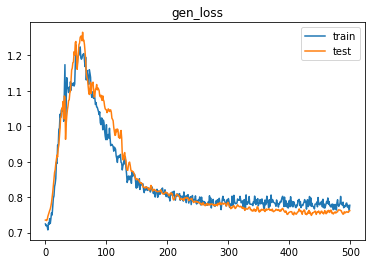

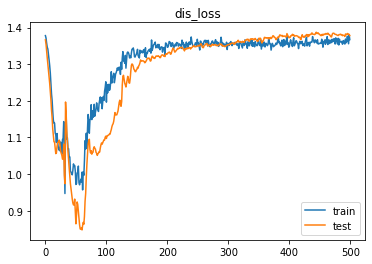

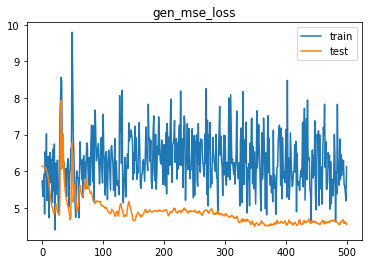

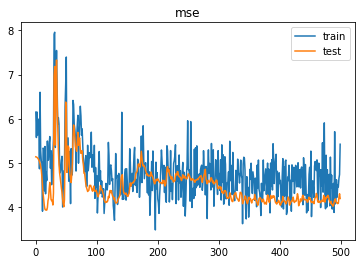

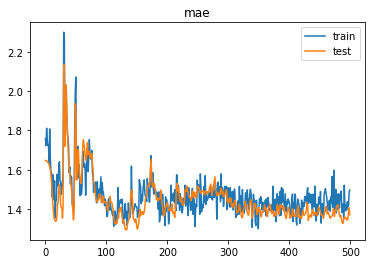

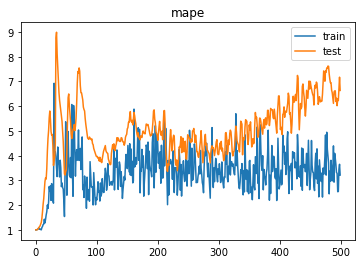

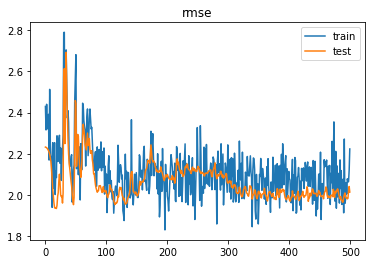

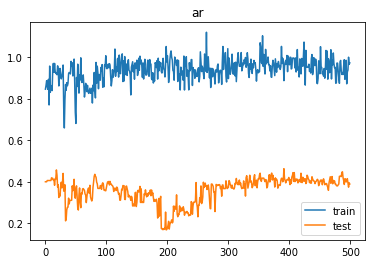

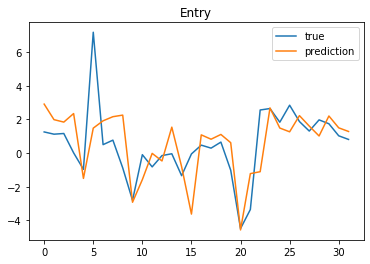

[MSE Baseline] train: 3.9610260466496223  test: 2.5058397803284445
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [0.90696102 1.05762386 4.91175699 3.93680263 1.3416872  3.46707582
 1.93412519 0.45748416]


In [41]:
i = 4 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
#data_path="GAN-stock-entry/datasets/"+data_name+".csv"
data_path="C:\\Users\\shusu\\WorkSpace\\stock_market_GAN\\datasets\\"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

## Results

In [42]:
df = pd.DataFrame(data = results, index = data_names, columns = metrics)
df.loc['mean'] = results.mean(axis=0)
df

,gen_loss,dis_loss,gen_mse_loss,mse,mae,mape,rmse,ar
GOOG,1.028764,1.098740,4.856074,5.555288,1.416463,1.439774,2.330847,0.583654
AAPL,1.072831,1.029039,4.960765,4.742755,1.517321,2.246149,2.167779,0.381166
AMZN,0.819267,1.271338,3.881046,3.422264,1.287734,8.076564,1.807446,0.485581
FB,1.162626,0.994042,6.666077,4.849424,1.528016,2.507830,2.148104,0.419894
TSLA,0.906961,1.057624,4.911757,3.936803,1.341687,3.467076,1.934125,0.457484
mean,0.998090,1.090156,5.055144,4.501307,1.418244,3.547478,2.077660,0.465556
